Analyzing AirBnB listings in the Twin Cities:
Exploratory data analysis and predicting price.
We will deal with different data types, missing data and imputation, and some minor feature engineering.
Then we will build a random forest reggresor model to predict the price of the AirBnB


Data from:
http://insideairbnb.com/get-the-data.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', 100)

There are four main files provided:

In [2]:
calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")
listings2 = pd.read_csv("listings2.csv")
reviews = pd.read_csv("reviews2.csv")

#We will mainly deal with the linstings files. The reviews provided the text reviews, which can be useful
#but require more extensive language processing that will be undergone here.
#calendar shows the times each listing was rented.

#Let's take a lot at calendar
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1221532,2020-02-13,f,$50.00,$50.00,30,1125
1,2441,2020-02-13,f,$82.00,$82.00,1,120
2,2441,2020-02-14,f,$95.00,$95.00,1,120
3,2441,2020-02-15,t,$79.00,$79.00,1,120
4,2441,2020-02-16,t,$79.00,$79.00,2,120


In [3]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523610 entries, 0 to 2523609
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           object
 4   adjusted_price  object
 5   minimum_nights  int64 
 6   maximum_nights  int64 
dtypes: int64(3), object(4)
memory usage: 134.8+ MB


In [4]:
#For practice, we can convert all object Dtypes to numerical or dt

calendar['date'] = pd.to_datetime(calendar['date'])
calendar['day_of_week'] = calendar['date'].dt.day_name()
calendar['day'] = calendar['date'].dt.dayofweek
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,day_of_week,day
0,1221532,2020-02-13,f,$50.00,$50.00,30,1125,Thursday,3
1,2441,2020-02-13,f,$82.00,$82.00,1,120,Thursday,3
2,2441,2020-02-14,f,$95.00,$95.00,1,120,Friday,4
3,2441,2020-02-15,t,$79.00,$79.00,1,120,Saturday,5
4,2441,2020-02-16,t,$79.00,$79.00,2,120,Sunday,6


In [5]:
#convert True (t) / False (f) to 1 and 0
def tfencode(x):
    if x == 't':
        return 1
    elif x =='f':
        return 0
    else:
        return x

calendar['available'] = calendar['available'].apply(tfencode)
calendar['available'].value_counts()

0    1591651
1     931959
Name: available, dtype: int64

In [6]:
#make $dollar amounts into float

calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].replace('[\$,]', '', regex=True).astype(float)


In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523610 entries, 0 to 2523609
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int64         
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  int64         
 6   maximum_nights  int64         
 7   day_of_week     object        
 8   day             int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 173.3+ MB


In [8]:
calendar.head(10)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,day_of_week,day
0,1221532,2020-02-13,0,50.0,50.0,30,1125,Thursday,3
1,2441,2020-02-13,0,82.0,82.0,1,120,Thursday,3
2,2441,2020-02-14,0,95.0,95.0,1,120,Friday,4
3,2441,2020-02-15,1,79.0,79.0,1,120,Saturday,5
4,2441,2020-02-16,1,79.0,79.0,2,120,Sunday,6
5,2441,2020-02-17,1,79.0,79.0,2,120,Monday,0
6,2441,2020-02-18,1,79.0,79.0,2,120,Tuesday,1
7,2441,2020-02-19,1,79.0,79.0,2,120,Wednesday,2
8,2441,2020-02-20,1,79.0,79.0,1,120,Thursday,3
9,2441,2020-02-21,1,79.0,79.0,1,120,Friday,4


In [9]:
calendar.isnull().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
day_of_week       0
day               0
dtype: int64

Now let's take a look at the listing tables, which we will analyse more closely:

In [10]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2441,"Cozy Artist’s Abode, ENTIRE Home-Wifi,NetFlix +",2680,Emily,NaN,Hennepin,45.00886,-93.23407,Entire home/apt,85,1,231,2020-01-07,1.84,2,176
1,4534,"Charming, 1 or 2BR + private bath, near downtown",5811,Rachel,NaN,Hennepin,44.94566,-93.35721,Private room,54,2,165,2020-01-17,1.40,1,347
2,27319,"Parks, Lakes, Downtown, Light rail",117283,Keith,NaN,Hennepin,44.91878,-93.23038,Private room,50,2,174,2019-12-15,1.53,2,360
3,55089,"Minneapolis/Edina ""Cabin"" on Creek",238546,Leslie,NaN,Hennepin,44.91985,-93.35141,Entire home/apt,150,2,32,2020-01-01,0.34,2,133
4,60977,Attic Loft with organic breakfast,294621,Habib,NaN,Ramsey,44.94800,-93.19037,Entire home/apt,65,3,20,2016-08-07,0.20,1,164


In [11]:
#Immediately, we see some features that will not be useful to us, and which we can drop:

listings.drop(columns = ['neighbourhood_group','name','host_name'], inplace=True)

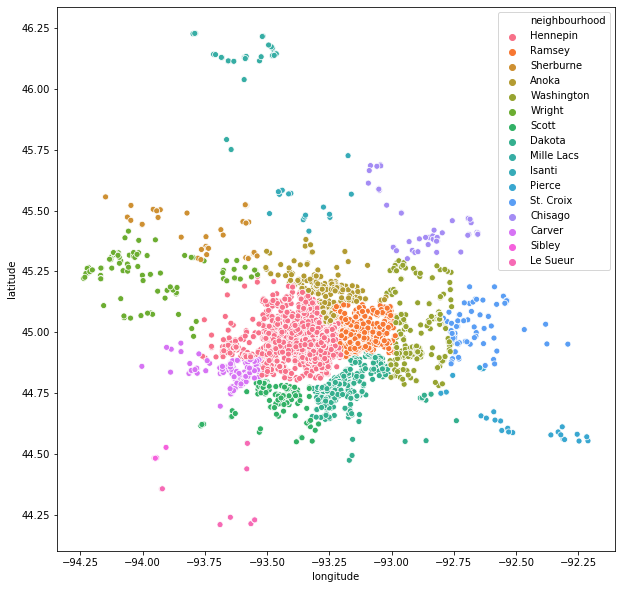

In [12]:
#Before we start, let's just take a look at the map of the AirBnB listings:

fig = plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude',y='latitude',hue='neighbourhood',data=listings)

In [13]:
#And the second, more detailed, listings file:
listings2.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2441,https://www.airbnb.com/rooms/2441,20200213183154,2020-02-13,"Cozy Artist’s Abode, ENTIRE Home-Wifi,NetFlix +",Make my home your homebase while you check out...,"This is a duplex house with a FULL kitchen, ba...",Make my home your homebase while you check out...,none,The area: Welcome to NE Minneapolis! Com...,"** For allergy sensitive people, I have a shor...",There is a major bus route 1 block from the ho...,This rental has its own private entrance. The ...,I generally give guests their peace while rent...,Requests for being a great guest: ** Please ha...,NaN,NaN,https://a0.muscache.com/im/pictures/2239815/5c...,NaN,2680,https://www.airbnb.com/users/show/2680,Emily,2008-09-02,"Minneapolis, Minnesota, United States","Hi, I'm Emily! I’ve been hosting on Airbnb sin...",within an hour,90%,82%,t,https://a0.muscache.com/im/pictures/user/82e5b...,https://a0.muscache.com/im/pictures/user/82e5b...,Windom Park,3.0,3.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Minneapolis, MN, United States",Windom Park,Hennepin,NaN,Minneapolis,MN,55418,Minneapolis,"Minneapolis, MN",US,United States,45.00886,-93.23407,...,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",800.0,$85.00,$600.00,"$2,400.00",$200.00,$50.00,2,$30.00,1,120,1,2,120,120,1.6,120.0,3 months ago,t,28,56,86,176,2020-02-13,231,20,2009-10-18,2020-01-07,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,"{""Minnesota State""}",f,f,strict_14_with_grace_period,f,f,2,2,0,0,1.84
1,4534,https://www.airbnb.com/rooms/4534,20200213183154,2020-02-13,"Charming, 1 or 2BR + private bath, near downtown",Our Airbnb in the Super Bowl news: (Website h...,Welcome. ברוכים הבאים. Bienvenidos. -------...,Our Airbnb in the Super Bowl news: (Website h...,none,"We are located in a friendly, safe, quiet subu...","Our home is NOT suitable for toddlers, as it i...",There is plenty of street parking near the hou...,"Wireless internet, access to a Vegetarian kitc...",Languages spoken in the house are English and ...,Our kitchen is Vegetarian. Please limit food p...,NaN,NaN,https://a0.muscache.com/im/pictures/1235366/76...,NaN,5811,https://www.airbnb.com/users/show/5811,Rachel,2008-12-30,"Minneapolis, Minnesota, United States",Well traveled. \r\nSchool social worker. \r\nL...,within an hour,100%,84%,t,https://a0.muscache.com/im/users/5811/profile_...

In [14]:
#There are 106 columns, most of which will not be useful to us. We can immediately drop those columns:

listings2.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'neighborhood_overview',
                       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
                       'require_guest_profile_picture', 'require_guest_phone_verification',
                       'summary','space','notes', 'transit',
                       'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
                       'picture_url', 'xl_picture_url','host_url', 'host_name',
                       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
                       'country_code', 'country','neighbourhood_group_cleansed',
                        'state','requires_license', 'license',
                       'jurisdiction_names','street','neighbourhood','name','description','host_about',
                       'host_location','host_verifications','smart_location',
                       'city', 'zipcode', 'market', 'property_type', 'amenities', 'bed_type',
                       'host_id','latitude','longitude','room_type','price','minimum_nights',
                        'number_of_reviews','last_review','reviews_per_month',
                        'calculated_host_listings_count','availability_365','neighbourhood_cleansed',
                       'calendar_last_scraped','host_total_listings_count','has_availability',
                       'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                       'maximum_nights','minimum_minimum_nights','availability_30','availability_60',
                       'availability_90'], inplace = True)

In [15]:
listings2.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'is_location_exact',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'number_of_reviews_ltm',
       'first_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')

In [16]:
listings2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 36 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6914 non-null   int64  
 1   host_since                                    6905 non-null   object 
 2   host_response_time                            3539 non-null   object 
 3   host_response_rate                            3539 non-null   object 
 4   host_acceptance_rate                          4186 non-null   object 
 5   host_is_superhost                             6905 non-null   object 
 6   host_listings_count                           6905 non-null   float64
 7   host_has_profile_pic                          6905 non-null   object 
 8   host_identity_verified                        6905 non-null   object 
 9   is_location_exact                             6914 non-null   o

In [17]:
#We are left with 36 columns and 6914 entries

listings2.head()

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2441,2008-09-02,within an hour,90%,82%,t,3.0,t,t,t,5,1.0,1.0,1.0,800.0,$600.00,"$2,400.00",$200.00,$50.00,2,$30.00,1.6,120.0,3 months ago,20,2009-10-18,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0,0
1,4534,2008-12-30,within an hour,100%,84%,t,1.0,t,t,t,5,1.0,2.0,2.0,NaN,NaN,NaN,NaN,$25.00,2,$20.00,2.0,21.0,2 months ago,17,2010-06-05,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0
2,27319,2010-05-02,within a day,88%,65%,t,2.0,t,f,t,3,1.0,2.0,2.0,1500.0,$335.00,$925.00,NaN,NaN,1,$10.00,2.0,60.0,4 months ago,12,2010-10-04,96.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2,0
3,55089,2010-09-18,within an hour,67%,91%,t,2.0,t,t,t,3,1.5,1.0,1.0,1.0,$800.00,"$2,150.00","$1,000.00",$75.00,2,$25.00,2.0,180.0,2 weeks ago,6,2012-06-28,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0
4,60977,2010-11-21,NaN,NaN,0%,f,1.0,t,t,t,4,1.0,1.0,2.0,NaN,$395.00,"$1,200.00",NaN,NaN,2,$25.00,3.0,30.0,12 months ago,0,2011-09-26,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0


# Convert all columns to numerical Dtype

In [18]:

#calculate how long the host has been registered

listings2['host_since'] = pd.to_datetime(listings2['host_since'])
listings2['host_since_days'] = pd.to_datetime('2020-03-09') - listings2['host_since']
listings2['host_since_days'] = listings2['host_since_days'] / np.timedelta64(1,'D')
listings2.drop(columns='host_since', inplace = True)

In [19]:
#Look at entries for response time:
listings2['host_response_time'].value_counts()

within an hour        2865
within a few hours     388
within a day           232
a few days or more      54
Name: host_response_time, dtype: int64

In [20]:
#label encode the host_response_time

listings2['host_response_time'] = listings2['host_response_time'].replace('within an hour', 3)
listings2['host_response_time'] = listings2['host_response_time'].replace('within a few hours', 2)
listings2['host_response_time'] = listings2['host_response_time'].replace('within a day', 1)
listings2['host_response_time'] = listings2['host_response_time'].replace('a few days or more', 0)
listings2['host_response_time'].value_counts()

3.0    2865
2.0     388
1.0     232
0.0      54
Name: host_response_time, dtype: int64

In [21]:
#covert percentage to float:
def p2f(x):
    x = str(x).strip('%')
    num = float(x)
    return num/100

listings2['host_response_rate'] = listings2['host_response_rate'].apply(p2f)
listings2['host_acceptance_rate'] = listings2['host_acceptance_rate'].apply(p2f)
listings2.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days
0,2441,3.0,0.90,0.82,t,3.0,t,t,t,5,1.0,1.0,1.0,800.0,$600.00,"$2,400.00",$200.00,$50.00,2,$30.00,1.6,120.0,3 months ago,20,2009-10-18,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0,0,4206.0
1,4534,3.0,1.00,0.84,t,1.0,t,t,t,5,1.0,2.0,2.0,NaN,NaN,NaN,NaN,$25.00,2,$20.00,2.0,21.0,2 months ago,17,2010-06-05,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,4087.0
2,27319,1.0,0.88,0.65,t,2.0,t,f,t,3,1.0,2.0,2.0,1500.0,$335.00,$925.00,NaN,NaN,1,$10.00,2.0,60.0,4 months ago,12,2010-10-04,96.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2,0,3599.0
3,55089,3.0,0.67,0.91,t,2.0,t,t,t,3,1.5,1.0,1.0,1.0,$800.00,"$2,150.00","$1,000.00",$75.00,2,$25.00,2.0,180.0,2 weeks ago,6,2012-06-28,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,3460.0
4,60977,NaN,NaN,0.00,f,1.0,t,t,t,4,1.0,1.0,2.0,NaN,$395.00,"$1,200.00",NaN,NaN,2,$25.00,3.0,30.0,12 months ago,0,2011-09-26,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,3396.0


In [22]:
#label encode True vs False, using same function from earlier:
    
listings2['host_is_superhost'] = listings2['host_is_superhost'].apply(tfencode)
listings2['host_has_profile_pic'] = listings2['host_has_profile_pic'].apply(tfencode)
listings2['host_identity_verified'] = listings2['host_identity_verified'].apply(tfencode)
listings2['is_location_exact'] = listings2['is_location_exact'].apply(tfencode)
listings2.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days
0,2441,3.0,0.90,0.82,1.0,3.0,1.0,1.0,1,5,1.0,1.0,1.0,800.0,$600.00,"$2,400.00",$200.00,$50.00,2,$30.00,1.6,120.0,3 months ago,20,2009-10-18,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0,0,4206.0
1,4534,3.0,1.00,0.84,1.0,1.0,1.0,1.0,1,5,1.0,2.0,2.0,NaN,NaN,NaN,NaN,$25.00,2,$20.00,2.0,21.0,2 months ago,17,2010-06-05,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,4087.0
2,27319,1.0,0.88,0.65,1.0,2.0,1.0,0.0,1,3,1.0,2.0,2.0,1500.0,$335.00,$925.00,NaN,NaN,1,$10.00,2.0,60.0,4 months ago,12,2010-10-04,96.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2,0,3599.0
3,55089,3.0,0.67,0.91,1.0,2.0,1.0,1.0,1,3,1.5,1.0,1.0,1.0,$800.00,"$2,150.00","$1,000.00",$75.00,2,$25.00,2.0,180.0,2 weeks ago,6,2012-06-28,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,3460.0
4,60977,NaN,NaN,0.00,0.0,1.0,1.0,1.0,1,4,1.0,1.0,2.0,NaN,$395.00,"$1,200.00",NaN,NaN,2,$25.00,3.0,30.0,12 months ago,0,2011-09-26,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,3396.0


In [23]:
#convert $dollars to float

listings2['weekly_price'] = listings2['weekly_price'].replace('[\$,]', '', regex=True).astype(float)
listings2['monthly_price'] = listings2['monthly_price'].replace('[\$,]', '', regex=True).astype(float)
listings2['security_deposit'] = listings2['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
listings2['cleaning_fee'] = listings2['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
listings2['extra_people'] = listings2['extra_people'].replace('[\$,]', '', regex=True).astype(float)

In [24]:
listings2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 36 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6914 non-null   int64  
 1   host_response_time                            3539 non-null   float64
 2   host_response_rate                            3539 non-null   float64
 3   host_acceptance_rate                          4186 non-null   float64
 4   host_is_superhost                             6905 non-null   float64
 5   host_listings_count                           6905 non-null   float64
 6   host_has_profile_pic                          6905 non-null   float64
 7   host_identity_verified                        6905 non-null   float64
 8   is_location_exact                             6914 non-null   int64  
 9   accommodates                                  6914 non-null   i

In [25]:
listings2.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days
0,2441,3.0,0.90,0.82,1.0,3.0,1.0,1.0,1,5,1.0,1.0,1.0,800.0,600.0,2400.0,200.0,50.0,2,30.0,1.6,120.0,3 months ago,20,2009-10-18,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0,0,4206.0
1,4534,3.0,1.00,0.84,1.0,1.0,1.0,1.0,1,5,1.0,2.0,2.0,NaN,NaN,NaN,NaN,25.0,2,20.0,2.0,21.0,2 months ago,17,2010-06-05,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,4087.0
2,27319,1.0,0.88,0.65,1.0,2.0,1.0,0.0,1,3,1.0,2.0,2.0,1500.0,335.0,925.0,NaN,NaN,1,10.0,2.0,60.0,4 months ago,12,2010-10-04,96.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2,0,3599.0
3,55089,3.0,0.67,0.91,1.0,2.0,1.0,1.0,1,3,1.5,1.0,1.0,1.0,800.0,2150.0,1000.0,75.0,2,25.0,2.0,180.0,2 weeks ago,6,2012-06-28,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,3460.0
4,60977,NaN,NaN,0.00,0.0,1.0,1.0,1.0,1,4,1.0,1.0,2.0,NaN,395.0,1200.0,NaN,NaN,2,25.0,3.0,30.0,12 months ago,0,2011-09-26,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,3396.0


In [26]:
#Now let's combine the two listings tables into one so that it is easier to deal with
#and to make sure we don't accidently lose any usefull information from one of the tables

listings = pd.merge(listings, listings2, on = 'id', suffixes = (False, False))
listings.head()

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days
0,2441,2680,Hennepin,45.00886,-93.23407,Entire home/apt,85,1,231,2020-01-07,1.84,2,176,3.0,0.90,0.82,1.0,3.0,1.0,1.0,1,5,1.0,1.0,1.0,800.0,600.0,2400.0,200.0,50.0,2,30.0,1.6,120.0,3 months ago,20,2009-10-18,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0,0,4206.0
1,4534,5811,Hennepin,44.94566,-93.35721,Private room,54,2,165,2020-01-17,1.40,1,347,3.0,1.00,0.84,1.0,1.0,1.0,1.0,1,5,1.0,2.0,2.0,NaN,NaN,NaN,NaN,25.0,2,20.0,2.0,21.0,2 months ago,17,2010-06-05,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,4087.0
2,27319,117283,Hennepin,44.91878,-93.23038,Private room,50,2,174,2019-12-15,1.53,2,360,1.0,0.88,0.65,1.0,2.0,1.0,0.0,1,3,1.0,2.0,2.0,1500.0,335.0,925.0,NaN,NaN,1,10.0,2.0,60.0,4 months ago,12,2010-10-04,96.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2,0,3599.0
3,55089,238546,Hennepin,44.91985,-93.35141,Entire home/apt,150,2,32,2020-01-01,0.34,2,133,3.0,0.67,0.91,1.0,2.0,1.0,1.0,1,3,1.5,1.0,1.0,1.0,800.0,2150.0,1000.0,75.0,2,25.0,2.0,180.0,2 weeks ago,6,2012-06-28,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,3460.0
4,60977,294621,Ramsey,44.94800,-93.19037,Entire home/apt,65,3,20,2016-08-07,0.20,1,164,NaN,NaN,0.00,0.0,1.0,1.0,1.0,1,4,1.0,1.0,2.0,NaN,395.0,1200.0,NaN,NaN,2,25.0,3.0,30.0,12 months ago,0,2011-09-26,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,3396.0


In [27]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6914 entries, 0 to 6913
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6914 non-null   int64  
 1   host_id                                       6914 non-null   int64  
 2   neighbourhood                                 6914 non-null   object 
 3   latitude                                      6914 non-null   float64
 4   longitude                                     6914 non-null   float64
 5   room_type                                     6914 non-null   object 
 6   price                                         6914 non-null   int64  
 7   minimum_nights                                6914 non-null   int64  
 8   number_of_reviews                             6914 non-null   int64  
 9   last_review                                   4407 non-null   o

In [28]:
#We can make a feature that is days since (last/firts) review. Calculate how long since first and last review
#This might affect people trying to rent if the first review was too recent or the last review was too distant
#people might be more careful

listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['first_review_days'] = pd.to_datetime('2020-03-09') - listings['first_review']
listings['first_review_days'] = listings['first_review_days'] / np.timedelta64(1,'D')
listings.drop(columns='first_review', inplace = True)

listings['last_review'] = pd.to_datetime(listings['last_review'])
listings['last_review_days'] = pd.to_datetime('2020-03-09') - listings['last_review']
listings['last_review_days'] = listings['last_review_days'] / np.timedelta64(1,'D')
listings.drop(columns='last_review', inplace = True)

listings.head()

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days,first_review_days,last_review_days
0,2441,2680,Hennepin,45.00886,-93.23407,Entire home/apt,85,1,231,1.84,2,176,3.0,0.90,0.82,1.0,3.0,1.0,1.0,1,5,1.0,1.0,1.0,800.0,600.0,2400.0,200.0,50.0,2,30.0,1.6,120.0,3 months ago,20,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0,0,4206.0,3795.0,62.0
1,4534,5811,Hennepin,44.94566,-93.35721,Private room,54,2,165,1.40,1,347,3.0,1.00,0.84,1.0,1.0,1.0,1.0,1,5,1.0,2.0,2.0,NaN,NaN,NaN,NaN,25.0,2,20.0,2.0,21.0,2 months ago,17,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,4087.0,3565.0,52.0
2,27319,117283,Hennepin,44.91878,-93.23038,Private room,50,2,174,1.53,2,360,1.0,0.88,0.65,1.0,2.0,1.0,0.0,1,3,1.0,2.0,2.0,1500.0,335.0,925.0,NaN,NaN,1,10.0,2.0,60.0,4 months ago,12,96.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2,0,3599.0,3444.0,85.0
3,55089,238546,Hennepin,44.91985,-93.35141,Entire home/apt,150,2,32,0.34,2,133,3.0,0.67,0.91,1.0,2.0,1.0,1.0,1,3,1.5,1.0,1.0,1.0,800.0,2150.0,1000.0,75.0,2,25.0,2.0,180.0,2 weeks ago,6,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,3460.0,2811.0,68.0
4,60977,294621,Ramsey,44.94800,-93.19037,Entire home/apt,65,3,20,0.20,1,164,NaN,NaN,0.00,0.0,1.0,1.0,1.0,1,4,1.0,1.0,2.0,NaN,395.0,1200.0,NaN,NaN,2,25.0,3.0,30.0,12 months ago,0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,3396.0,3087.0,1310.0


In [29]:
#Let's see some of the more expensive listings:

listings['price'].sort_values(ascending = False)

1608    15000
3860    10000
2066    10000
3438    10000
3783    10000
        ...  
5602       10
6059       10
1779       10
706        10
1479        0
Name: price, Length: 6914, dtype: int64

In [30]:
#Not clear how there can be listings this high!
#Let's look at a few of the data points:

listings[listings['price']>=4000]

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days,first_review_days,last_review_days
632,11527860,60788667,Carver,44.82552,-93.58211,Entire home/apt,5000,1,0,NaN,1,365,1.0,0.5,NaN,0.0,1.0,1.0,0.0,1,8,3.5,5.0,5.0,NaN,NaN,NaN,NaN,NaN,1,0.0,1.0,1125.0,2 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1471.0,NaN,NaN
666,11984602,64053314,Carver,44.87308,-93.58551,Entire home/apt,10000,1,1,0.02,1,0,NaN,NaN,NaN,0.0,1.0,1.0,0.0,1,10,4.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,1,0.0,1.0,1125.0,43 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1448.0,1342.0,1342.0
726,12645798,68683865,Scott,44.73631,-93.37169,Entire home/apt,5000,1,0,NaN,1,0,NaN,NaN,NaN,0.0,1.0,1.0,0.0,1,7,2.5,4.0,4.0,NaN,NaN,NaN,NaN,NaN,1,0.0,1.0,1125.0,46 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1415.0,NaN,NaN
909,14072464,84533377,Hennepin,44.88301,-93.38721,Entire home/apt,5500,5,0,NaN,3,362,NaN,NaN,NaN,0.0,3.0,1.0,0.0,1,10,2.5,4.0,5.0,NaN,NaN,NaN,2000.0,1000.0,1,0.0,5.0,12.0,25 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,1330.0,NaN,NaN
1069,14977428,94359970,Hennepin,44.90294,-93.33098,Entire home/apt,7000,7,0,NaN,1,358,NaN,NaN,NaN,0.0,1.0,1.0,0.0,1,6,2.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,1,0.0,7.0,14.0,42 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1277.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468,23046148,62843272,Hennepin,44.99759,-93.54802,Entire home/apt,6000,3,0,NaN,1,0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1,10,4.5,0.0,5.0,NaN,NaN,NaN,NaN,NaN,1,0.0,3.0,3.0,25 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1457.0,NaN,NaN
4470,23046348,162003248,Hennepin,44.98492,-93.31115,Private room,5000,2,0,NaN,1,0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1,3,2.5,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1,0.0,2.0,7.0,25 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,821.0,NaN,NaN
4504,23062396,171197695,Carver,44.87012,-93.64632,Entire home/apt,4500,2,0,NaN,1,365,NaN,NaN,NaN,0.0,1.0,1.0,0.0,1,10,2.5,3.0,3.0,NaN,NaN,NaN,NaN,NaN,1,0.0,2.0,4.0,25 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,767.0,NaN,NaN
4615,24326381,24051954,Dakota,44.84694,-93.07888,Entire home/apt,4000,3,1,0.05,71,360,3.0,1.0,0.99,1.0,78.0,1.0,1.0,1,15,12.0,8.0,8.0,NaN,NaN,NaN,2500.0,459.0,16,100.0,3.0,360.0,today,0,100.0,8.0,10.0,10.0,10.0,10.0,8.0,71,0,0,1934.0,623.0,623.0


In [31]:
#Only a couple of these seem to have been reviewed. What do they say?

pd.set_option('display.max_colwidth', 10000)
reviews[reviews['listing_id']==11984602]['comments']

36925    The host canceled this reservation 84 days before arrival. This is an automated posting.
Name: comments, dtype: object

In [32]:
reviews[reviews['listing_id']==24326381]['comments']

117935    .
Name: comments, dtype: object

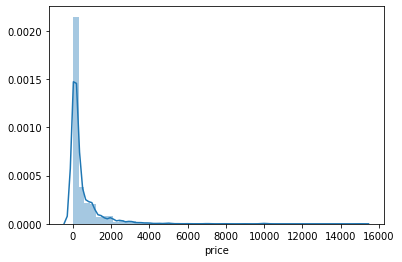

In [33]:
#Let's look at the overall distribution of prices:
sns.distplot(listings['price'])

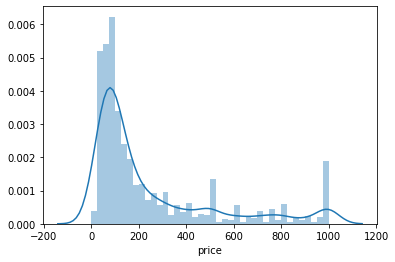

In [34]:
#There is a huge tail on the price. It will be difficult to compare to super high priced rentals.
#These seem to be outliers. Let's restrict out data to $1000 per night as upper limit:

listings = listings[listings['price']<=1000]
sns.distplot(listings['price'])

# Look at missing data:

In [35]:
#as a percentage of total data
listings.isnull().sum()

id                                                 0
host_id                                            0
neighbourhood                                      0
latitude                                           0
longitude                                          0
room_type                                          0
price                                              0
minimum_nights                                     0
number_of_reviews                                  0
reviews_per_month                               1738
calculated_host_listings_count                     0
availability_365                                   0
host_response_time                              2571
host_response_rate                              2571
host_acceptance_rate                            1937
host_is_superhost                                  9
host_listings_count                                9
host_has_profile_pic                               9
host_identity_verified                        

In [36]:
#Drop the columns that have majority missing data:
listings.drop(columns = ['square_feet','weekly_price','monthly_price'], inplace = True)

In [37]:
#Let's look at some statistics to see if we can educatedly impute missing data:

listings[['security_deposit','cleaning_fee','host_response_time',
          'host_response_rate','host_acceptance_rate',
         'host_is_superhost','host_identity_verified']].describe()

,security_deposit,cleaning_fee,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified
count,4062.000000,4380.000000,3459.000000,3459.000000,4093.000000,6021.000000,6021.000000
mean,308.422944,67.181507,2.723909,0.970786,0.893347,0.356585,0.350938
std,561.341930,68.329272,0.637495,0.127310,0.201063,0.479031,0.477303
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,3.000000,1.000000,0.890000,0.000000,0.000000
50%,150.000000,50.000000,3.000000,1.000000,0.980000,0.000000,0.000000
75%,400.000000,100.000000,3.000000,1.000000,1.000000,1.000000,1.000000
max,5000.000000,619.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
#Impute missing data based on mean, median, or value

listings['security_deposit'] = listings['security_deposit'].fillna(listings['security_deposit'].median())
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(listings['cleaning_fee'].median())
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)
listings['host_is_superhost'] = listings['host_is_superhost'].fillna(0)
listings['host_identity_verified'] = listings['host_identity_verified'].fillna(listings['host_identity_verified'].median())

listings['host_has_profile_pic'] = listings['host_has_profile_pic'].fillna(listings['host_has_profile_pic'].median())
listings['host_listings_count'] = listings['host_listings_count'].fillna(listings['host_listings_count'].median())
listings['host_response_time'] = listings['host_response_time'].fillna(listings['host_response_time'].median())
listings['host_response_rate'] = listings['host_response_rate'].fillna(listings['host_response_rate'].mean())
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].fillna(listings['host_acceptance_rate'].mean())

In [39]:
listings.isnull().sum()

id                                                 0
host_id                                            0
neighbourhood                                      0
latitude                                           0
longitude                                          0
room_type                                          0
price                                              0
minimum_nights                                     0
number_of_reviews                                  0
reviews_per_month                                  0
calculated_host_listings_count                     0
availability_365                                   0
host_response_time                                 0
host_response_rate                                 0
host_acceptance_rate                               0
host_is_superhost                                  0
host_listings_count                                0
host_has_profile_pic                               0
host_identity_verified                        

In [40]:
#Look at data point with missing room information:
listings[listings[['bathrooms','bedrooms','beds']].isnull().any(axis=1)]

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days,first_review_days,last_review_days
40,697236,3505142,Hennepin,44.87676,-93.28388,Private room,40,1,68,0.77,1,349,3.0,1.000000,0.840000,0.0,1.0,1.0,1.0,1,2,NaN,1.0,1.0,150.0,30.0,2,10.0,1.0,1125.0,6 months ago,10,91.0,9.0,9.0,9.0,9.0,9.0,9.0,0,1,0,2739.0,2681.0,37.0
712,12514055,67770016,Ramsey,44.94574,-93.08884,Entire home/apt,150,1,27,0.60,3,364,2.0,1.000000,0.540000,0.0,3.0,1.0,0.0,0,2,1.0,NaN,1.0,150.0,50.0,1,0.0,1.0,1125.0,7 months ago,5,98.0,10.0,10.0,10.0,10.0,10.0,10.0,3,0,0,1421.0,1366.0,148.0
713,12519169,67770016,Ramsey,44.94739,-93.08957,Entire home/apt,150,1,42,0.91,3,363,2.0,1.000000,0.540000,0.0,3.0,1.0,0.0,0,2,1.0,NaN,1.0,0.0,50.0,1,0.0,1.0,21.0,12 months ago,0,93.0,9.0,10.0,10.0,10.0,10.0,9.0,3,0,0,1421.0,1408.0,526.0
5435,32963415,66969451,Ramsey,44.92383,-93.13474,Entire home/apt,59,2,8,5.00,1,55,3.0,1.000000,1.000000,0.0,0.0,1.0,0.0,1,3,1.0,NaN,2.0,0.0,35.0,1,0.0,2.0,1125.0,3 weeks ago,8,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,1427.0,72.0,28.0
6064,37394217,48677749,Hennepin,44.98625,-93.25279,Entire home/apt,90,1,6,1.04,1,87,1.0,1.000000,0.920000,0.0,1.0,1.0,1.0,0,2,1.0,NaN,1.0,150.0,50.0,1,0.0,1.0,1125.0,2 months ago,6,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,1581.0,197.0,120.0
6121,37809565,25191849,Hennepin,45.01136,-93.27014,Private room,40,15,0,0.00,1,90,3.0,0.970786,0.893347,0.0,0.0,1.0,1.0,1,1,NaN,1.0,1.0,150.0,50.0,1,0.0,15.0,1125.0,6 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1901.0,NaN,NaN
6378,39461729,303113890,Ramsey,45.09567,-93.22704,Private room,79,1,0,0.00,1,0,3.0,0.970786,0.893347,0.0,1.0,0.0,0.0,0,2,1.0,NaN,1.0,150.0,50.0,1,0.0,1.0,5.0,4 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,143.0,NaN,NaN
6606,40507150,313597206,Hennepin,44.96570,-93.28995,Entire home/apt,51,1,5,2.54,2,0,3.0,1.000000,1.000000,1.0,2.0,1.0,0.0,0,2,1.0,NaN,NaN,150.0,50.0,1,0.0,1.0,1125.0,4 weeks ago,5,100.0,10.0,9.0,10.0,10.0,10.0,9.0,2,0,0,99.0,83.0,49.0
6639,40680056,315683590,Scott,44.71872,-93.36734,Private room,90,28,0,0.00,1,180,3.0,0.970786,0.893347,0.0,0.0,1.0,0.0,1,4,2.0,1.0,NaN,100.0,25.0,1,50.0,28.0,28.0,2 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,92.0,NaN,NaN
6676,40861377,32869122,Hennepin,44.95267,-93.28646,Private room,55,1,2,1.28,1,87,2.0,1.000000,1.000000,0.0,0.0,1.0,0.0,1,3,1.0,1.0,NaN,150.0,50.0,1,0.0,1.0,1125.0,6 weeks ago,2,100.0,10.0,9.0,10.0,10.0,9.0,10.0,0,1,0,1768.0,71.0,45.0


In [41]:
listings[['bathrooms','bedrooms','beds']].describe()

,bathrooms,bedrooms,beds
count,6028.000000,6022.000000,6015.000000
mean,1.446831,1.924942,2.494431
std,0.766794,1.303100,1.986886
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000
75%,2.000000,3.000000,3.000000
max,10.000000,11.000000,24.000000


In [42]:
#Impute

#only two data points missing bathroom information, and they both have 1 bed, so we can say 1 bathroom
listings['bathrooms'] = listings['bathrooms'].fillna(1)

#Estimate one bedroom per bed
listings['bedrooms'] = listings['bedrooms'].fillna(listings['beds'])

#Estimate one bedroom for data points without listing of bed
listings['bedrooms'] = listings['bedrooms'].fillna(1)

#Estimate one bed per bedroom
listings['beds'] = listings['beds'].fillna(listings['bedrooms'])

In [43]:
#Now to host_since_days column:
listings[listings[['host_since_days']].isnull().any(axis=1)]

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days,first_review_days,last_review_days
459,9032151,47145194,Washington,44.94140,-92.90267,Private room,40,5,16,0.49,1,364,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,0,1,1.5,1.0,1.0,150.0,10.0,1,0.0,5.0,1125.0,2 months ago,3,99.0,10.0,10.0,10.0,10.0,9.0,10.0,0,1,0,NaN,1002.0,177.0
560,10910737,22258656,Chisago,45.32978,-92.72166,Private room,55,1,50,1.06,1,12,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,1,2,1.0,1.0,1.0,150.0,50.0,1,20.0,1.0,3.0,6 months ago,10,93.0,10.0,9.0,10.0,10.0,10.0,9.0,0,1,0,NaN,1436.0,190.0
1269,16986974,25116055,Chisago,45.33676,-92.91645,Private room,45,30,0,0.00,1,365,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,0,1,1.0,1.0,1.0,150.0,50.0,1,0.0,30.0,90.0,17 months ago,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,NaN,NaN,NaN
1683,19950599,41215632,Pierce,44.55263,-92.24672,Private room,94,2,13,0.60,1,362,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,1,3,1.0,1.0,1.0,0.0,40.0,2,45.0,1.3,1125.0,5 months ago,12,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,NaN,673.0,148.0
4856,27465299,206975273,Le Sueur,44.21279,-93.56472,Private room,20,1,1,0.05,1,179,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,1,1,1.0,1.0,1.0,150.0,50.0,1,0.0,1.0,2.0,19 months ago,0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,NaN,575.0,575.0
5951,36672215,203118905,Carver,44.85981,-94.00273,Entire home/apt,300,2,1,0.18,1,353,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,1,6,1.5,2.0,2.0,250.0,85.0,4,10.0,2.0,10.0,3 months ago,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,NaN,189.0,189.0
6289,38881767,297776585,Carver,44.88318,-93.74046,Entire home/apt,55,1,10,2.36,1,238,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,1,2,1.0,1.0,1.0,150.0,50.0,1,0.0,1.0,1125.0,4 weeks ago,10,92.0,10.0,8.0,10.0,10.0,10.0,10.0,1,0,0,NaN,151.0,92.0
6642,40703591,67891881,Hennepin,45.05118,-93.75185,Entire home/apt,85,1,4,2.61,1,167,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,1,6,1.0,0.0,1.0,0.0,10.0,1,0.0,1.0,1125.0,today,4,95.0,10.0,10.0,10.0,10.0,10.0,9.0,1,0,0,NaN,70.0,29.0
6773,41351640,211909376,St. Croix,45.18675,-92.58638,Private room,17,31,1,1.00,1,365,3.0,0.970786,0.893347,0.0,1.0,1.0,0.0,1,1,1.0,1.0,1.0,150.0,50.0,1,0.0,31.0,1125.0,never,1,100.0,10.0,10.0,10.0,10.0,6.0,10.0,0,1,0,NaN,31.0,31.0


In [44]:
#We can estimate and put a lower bound on the host_since_days by making it the same as the first review

listings['host_since_days'] = listings['host_since_days'].fillna(listings['first_review_days'])

#With a single data point left, we make it the date of when the calendar was last updated
listings['host_since_days'] = listings['host_since_days'].fillna(17*30)

In [45]:
listings.isnull().sum()

id                                                 0
host_id                                            0
neighbourhood                                      0
latitude                                           0
longitude                                          0
room_type                                          0
price                                              0
minimum_nights                                     0
number_of_reviews                                  0
reviews_per_month                                  0
calculated_host_listings_count                     0
availability_365                                   0
host_response_time                                 0
host_response_rate                                 0
host_acceptance_rate                               0
host_is_superhost                                  0
host_listings_count                                0
host_has_profile_pic                               0
host_identity_verified                        

In [46]:
#Now only review information is missing

listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6030 entries, 0 to 6913
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6030 non-null   int64  
 1   host_id                                       6030 non-null   int64  
 2   neighbourhood                                 6030 non-null   object 
 3   latitude                                      6030 non-null   float64
 4   longitude                                     6030 non-null   float64
 5   room_type                                     6030 non-null   object 
 6   price                                         6030 non-null   int64  
 7   minimum_nights                                6030 non-null   int64  
 8   number_of_reviews                             6030 non-null   int64  
 9   reviews_per_month                             6030 non-null   f

In [47]:
#Lets move back to making all data types numerical:
#Look at all entries in the text column of calendar_updated

listings['calendar_updated'].value_counts()

25 months ago    879
today            603
2 weeks ago      350
a week ago       329
2 months ago     287
                ... 
68 months ago      1
58 months ago      1
64 months ago      1
55 months ago      1
70 months ago      1
Name: calendar_updated, Length: 77, dtype: int64

In [48]:
#We can chance this string to the number if days ago:

def cal_up(x):
    x=str(x)
    listed = x.split(' ')
    if listed[0] == 'a':
        num = 1
    elif listed[0] == 'today':
        return 0
    elif listed[0] == 'yesterday':
        return 1
    elif listed[0] == 'never':
        return None
    else:
        num = int(listed[0])
        
    if 'week' in x:
        multiplier = 7
    elif 'month' in x:
        multiplier = 30
    elif 'day' in x:
        multiplier = 1
    else:
        multiplier = -1
        
    return (num * multiplier)

In [49]:
listings['calendar_updated'] = listings['calendar_updated'].apply(cal_up)
listings['calendar_updated'] = listings['calendar_updated'].fillna(listings['host_since_days'])
listings['calendar_updated'].value_counts()

750.0     879
0.0       603
7.0       362
14.0      350
60.0      287
         ... 
1740.0      1
2100.0      1
1435.0      1
1662.0      1
2413.0      1
Name: calendar_updated, Length: 87, dtype: int64

In [50]:
#Now lets look at the room_type

listings['room_type'].value_counts()

Entire home/apt    4027
Private room       1923
Shared room          51
Hotel room           29
Name: room_type, dtype: int64

In [51]:
def room_ty(x):
    if 'Entire' in x:
        return 3
    elif 'Private' in x:
        return 2
    elif 'Hotel' in x:
        return 1
    elif 'Shared' in x:
        return 0
    
listings['room_type'] = listings['room_type'].apply(room_ty)
listings['room_type'].value_counts()

3    4027
2    1923
0      51
1      29
Name: room_type, dtype: int64

In [52]:
#And the neighbourhood:
listings['neighbourhood'].value_counts()

Hennepin      3703
Ramsey         986
Anoka          252
Dakota         250
Washington     211
Carver         170
Scott          106
Wright          91
St. Croix       80
Chisago         52
Sherburne       41
Mille Lacs      32
Pierce          25
Isanti          15
Le Sueur         9
Sibley           7
Name: neighbourhood, dtype: int64

In [53]:
#Difficult to label encode neighbourhood because their is no clear hierarchy, so we can one-hot encode
#But there are some neighbourhoods with few data entries, so combine those. This makes sense because they
#also happen to all be outside of the metro area of the cities:

def neigh_imp(x):
    if x in ['Le Sueur', 'Sibley', 'Mille Lacs', 'Sherburne',
             'Wright', 'Chisago', 'St. Croix', 'Pierce', 'Isanti']:
        return 'Other'
    else:
        return x

listings['neighbourhood'] = listings['neighbourhood'].apply(neigh_imp)
listings['neighbourhood'].value_counts()

Hennepin      3703
Ramsey         986
Other          352
Anoka          252
Dakota         250
Washington     211
Carver         170
Scott          106
Name: neighbourhood, dtype: int64

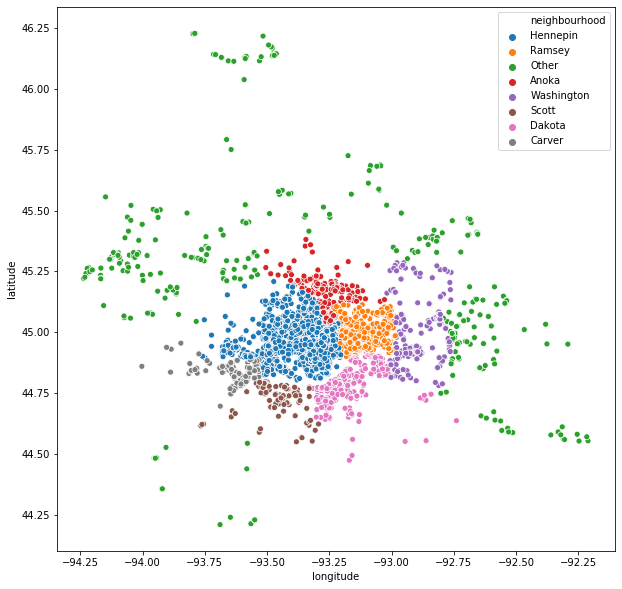

In [54]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude',y='latitude',hue='neighbourhood',data=listings)

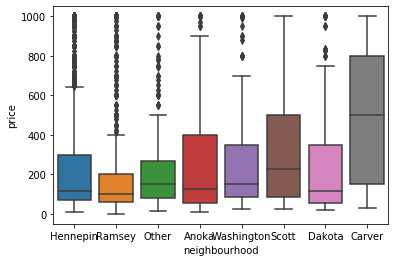

In [55]:
#How does the price look for each neighbourhood?
sns.boxplot(x = 'neighbourhood', y = 'price', data = listings)

It seems that there are more cheap options in the metro area, and outside the cities, 
a smaller percentage of the listings are cheap options

In [56]:
#One hot encode neighbourhood

neighbourhood = pd.get_dummies(listings['neighbourhood'],drop_first=False)

listings.drop('neighbourhood',axis=1,inplace=True)
listings = pd.concat([listings,neighbourhood],axis=1)
listings.head()

,id,host_id,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days,first_review_days,last_review_days,Anoka,Carver,Dakota,Hennepin,Other,Ramsey,Scott,Washington
0,2441,2680,45.00886,-93.23407,3,85,1,231,1.84,2,176,3.0,0.900000,0.82,1.0,3.0,1.0,1.0,1,5,1.0,1.0,1.0,200.0,50.0,2,30.0,1.6,120.0,90.0,20,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0,0,4206.0,3795.0,62.0,0,0,0,1,0,0,0,0
1,4534,5811,44.94566,-93.35721,2,54,2,165,1.40,1,347,3.0,1.000000,0.84,1.0,1.0,1.0,1.0,1,5,1.0,2.0,2.0,150.0,25.0,2,20.0,2.0,21.0,60.0,17,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,4087.0,3565.0,52.0,0,0,0,1,0,0,0,0
2,27319,117283,44.91878,-93.23038,2,50,2,174,1.53,2,360,1.0,0.880000,0.65,1.0,2.0,1.0,0.0,1,3,1.0,2.0,2.0,150.0,50.0,1,10.0,2.0,60.0,120.0,12,96.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2,0,3599.0,3444.0,85.0,0,0,0,1,0,0,0,0
3,55089,238546,44.91985,-93.35141,3,150,2,32,0.34,2,133,3.0,0.670000,0.91,1.0,2.0,1.0,1.0,1,3,1.5,1.0,1.0,1000.0,75.0,2,25.0,2.0,180.0,14.0,6,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,3460.0,2811.0,68.0,0,0,0,1,0,0,0,0
4,60977,294621,44.94800,-93.19037,3,65,3,20,0.20,1,164,3.0,0.970786,0.00,0.0,1.0,1.0,1.0,1,4,1.0,1.0,2.0,150.0,50.0,2,25.0,3.0,30.0,360.0,0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,3396.0,3087.0,1310.0,0,0,0,0,0,1,0,0


In [57]:
#There are about 1/3 of the listings with no reviews, so lets take those rows away

listings_no_reviews = listings[listings[['first_review_days']].isnull().any(axis=1)].copy()
listings.dropna(inplace = True)

In [58]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4215 entries, 0 to 6875
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4215 non-null   int64  
 1   host_id                                       4215 non-null   int64  
 2   latitude                                      4215 non-null   float64
 3   longitude                                     4215 non-null   float64
 4   room_type                                     4215 non-null   int64  
 5   price                                         4215 non-null   int64  
 6   minimum_nights                                4215 non-null   int64  
 7   number_of_reviews                             4215 non-null   int64  
 8   reviews_per_month                             4215 non-null   float64
 9   calculated_host_listings_count                4215 non-null   i

In [59]:
#Now all of the data is numerical, and there is none missing.

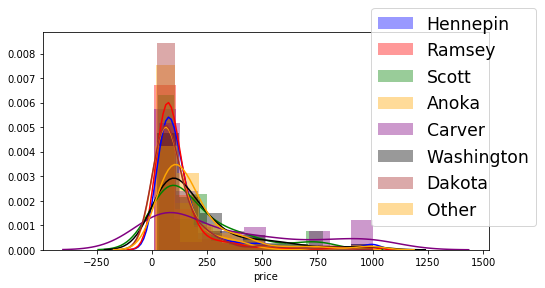

In [60]:
#Lets look at another way to visualize the prices in each neighbourhood:

fig = plt.figure(figsize=(8,4))
sns.distplot(listings[listings['Hennepin']==1]['price'], color = 'blue', bins=10)
sns.distplot(listings[listings['Ramsey']==1]['price'], color = 'red', bins=10)
sns.distplot(listings[listings['Scott']==1]['price'], color = 'green', bins=10)
sns.distplot(listings[listings['Anoka']==1]['price'], color = 'orange', bins=10)
sns.distplot(listings[listings['Carver']==1]['price'], color = 'purple', bins=10)
sns.distplot(listings[listings['Washington']==1]['price'], color = 'black', bins=10)
sns.distplot(listings[listings['Dakota']==1]['price'], color = 'brown', bins=10)
sns.distplot(listings[listings['Other']==1]['price'], color = 'orange', bins=10)
fig.legend(labels=['Hennepin','Ramsey','Scott','Anoka','Carver','Washington','Dakota','Other'], loc = 1, fontsize = 'xx-large')

In [61]:
#How does one become a superhost? lets look at some the features of superhost vs. no superhost

listings.groupby('host_is_superhost').mean()

,id,host_id,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days,first_review_days,last_review_days,Anoka,Carver,Dakota,Hennepin,Other,Ramsey,Scott,Washington
host_is_superhost,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,2.432224e+07,9.924629e+07,44.977365,-93.267769,2.653688,200.605131,4.078333,18.616583,1.120733,4.088410,133.874943,2.791113,0.959304,0.867166,35.629409,0.998626,0.335776,0.841961,4.934494,1.456024,1.971599,2.614292,235.999084,62.746221,2.356848,13.460834,4.205634,653.673339,242.540541,7.740266,95.016033,9.654146,9.476867,9.785616,9.770041,9.721484,9.491984,3.214842,0.727439,0.027027,1424.981219,706.487861,338.705451,0.037105,0.017407,0.034356,0.634906,0.067339,0.161246,0.015575,0.032066
1.0,2.412414e+07,8.223860e+07,44.979455,-93.247061,2.639272,124.325295,2.726870,55.777067,2.475069,8.606791,176.376476,2.832185,0.990270,0.947441,13.998524,0.999508,0.470965,0.850394,4.367126,1.326033,1.723425,2.297244,220.777067,57.768701,2.227854,12.892224,2.930610,595.678199,40.113681,25.013780,97.805610,9.939961,9.862205,9.937008,9.960138,9.916339,9.836122,6.509843,2.061024,0.014272,1570.592028,735.084154,96.872539,0.028543,0.014764,0.028543,0.641732,0.066437,0.177165,0.009350,0.033465


In [62]:
listings.corr()['host_is_superhost'].sort_values()

last_review_days                               -0.406805
calendar_updated                               -0.391021
price                                          -0.198416
host_id                                        -0.104007
bedrooms                                       -0.097150
accommodates                                   -0.088172
bathrooms                                      -0.086919
beds                                           -0.078586
host_listings_count                            -0.060989
maximum_nights_avg_ntm                         -0.049333
cleaning_fee                                   -0.043760
minimum_nights                                 -0.040167
minimum_nights_avg_ntm                         -0.039331
calculated_host_listings_count_shared_rooms    -0.033995
guests_included                                -0.029052
Scott                                          -0.027913
Anoka                                          -0.023956
security_deposit               

Here we see that superhosts get more reviews, higher reviews, and possibly have lower prices.
Superhosts are also likely to have more listings.

In [63]:
#Let's look at what correlates to high reviews:
listings.corr()['review_scores_rating'].sort_values(ascending = False)

review_scores_rating                            1.000000
review_scores_accuracy                          0.752606
review_scores_cleanliness                       0.717459
review_scores_value                             0.692912
review_scores_communication                     0.655982
review_scores_checkin                           0.572727
review_scores_location                          0.538012
host_is_superhost                               0.209137
number_of_reviews                               0.071811
number_of_reviews_ltm                           0.068943
reviews_per_month                               0.061728
host_identity_verified                          0.060441
host_response_rate                              0.053108
Other                                           0.043629
host_acceptance_rate                            0.039745
first_review_days                               0.036134
Carver                                          0.032058
security_deposit               

Review scores have a positive correlation to review rates, so people seem more likely to review if they
like the rental.
Review scores is also negatively correlated to host listings count, so more properties -> lower review score.
This could be argued either was (before knowing the correlation): more properties makes a host more experienced
and possibly a professional. Lower properties could be argued that the host pays more attention to the propertie,
or maybe it is their full time home that they are temporarily renting, so it is in good living conditions.

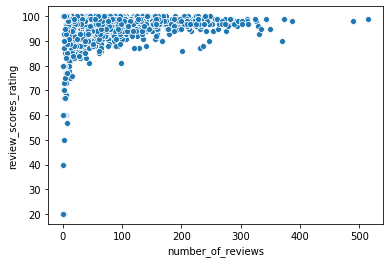

In [64]:
sns.scatterplot(x='number_of_reviews', y = 'review_scores_rating',data = listings)

In general, people give good reviews. The only properties with poor reviews have low number of reviews.
This could also be an AirBnB policy, where to be able to host, you have to get above a certain review score threshold.
Also, less people will tend to rent place with low review scores, which would lead to less overall number of reviews.

In [65]:
#Lets look at the overall correlation matrix to see all correlations. There is possibly some features that are
#highly correlated and possibly can be thrown out:

listings.corr()

,id,host_id,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_since_days,first_review_days,last_review_days,Anoka,Carver,Dakota,Hennepin,Other,Ramsey,Scott,Washington
id,1.000000,0.459809,0.032513,0.018654,0.089252,-0.039107,-0.079233,-0.366967,0.183026,0.232498,-0.015916,0.062733,0.028040,0.150943,-0.009604,0.091150,-0.003426,-0.252745,-0.034171,0.048386,0.005921,-0.016130,0.021316,-0.080525,0.038679,0.042291,-0.066365,-0.071791,0.052828,-0.248218,-0.031767,-0.060697,-0.061706,-0.039884,-0.125460,-0.086363,-0.033644,-0.053782,0.229165,0.058068,0.011422,-0.416286,-0.922135,-0.322541,0.032303,-0.048205,-0.000593,0.013309,0.016254,-0.026628,0.011076,-0.007335
host_id,0.459809,1.000000,0.074410,-0.002769,0.039352,-0.019816,-0.054311,-0.172903,0.103012,0.005230,0.010242,0.031905,-0.025024,0.097416,-0.104007,-0.073685,-0.011887,-0.445875,-0.019281,0.033060,0.052974,0.002474,0.024170,-0.013412,-0.029399,0.024162,-0.012159,-0.055415,0.017079,-0.074109,-0.017402,-0.050638,-0.042755,-0.036403,-0.067348,-0.058406,-0.024094,-0.049550,0.051862,-0.119178,0.023208,-0.908027,-0.425920,-0.130698,0.039933,0.007790,0.052703,-0.090348,0.101993,-0.014224,0.030016,0.014554
latitude,0.032513,0.074410,1.000000,-0.141862,0.032757,0.021507,-0.016056,-0.038279,-0.035640,-0.032864,0.081966,-0.064931,-0.021047,0.017440,0.006989,-0.002278,0.006369,-0.063832,-0.017082,0.100470,0.055033,0.067348,0.136958,0.013352,0.038864,0.050262,-0.012017,-0.019168,0.002874,-0.065363,-0.034388,0.012352,-0.002554,0.002095,0.018430,0.004774,0.004017,0.031976,-0.027316,-0.018098,-0.005429,-0.058567,-0.036205,-0.044824,0.203519,-0.123972,-0.236726,-0.179031,0.521705,-0.031301,-0.195059,0.055053
longitude,0.018654,-0.002769,-0.141862,1.000000,-0.033212,-0.076136,-0.008007,0.072768,0.074655,-0.012016,0.025913,0.015741,0.036252,0.043259,0.051301,-0.011097,0.013884,0.002778,-0.033451,-0.059190,-0.073268,-0.072154,-0.090135,-0.029712,-0.077005,-0.003297,0.021977,-0.006467,0.001752,-0.037911,0.075676,0.001098,0.009526,0.012367,0.007527,0.012070,-0.015408,-0.002055,-0.023768,0.027710,-0.022249,-0.001771,-0.012385,-0.068137,0.001578,-0.235587,0.097509,-0.264915,-0.066772,0.287095,-0.106707,0.340843
room_type,0.089252,0.039352,0.032757,-0.033212,1.000000,0.302535,0.036821,0.000877,0.067625,0.087489,0.055583,-0.010541,-0.009464,0.055507,-0.013585,0.077068,-0.006002,-0.031030,0.021984,0.465100,0.160594,0.381236,0.373354,0.151271,0.367179,0.283304,0.045592,0.043996,0.038729,-0.040094,0.041342,-0.040058,-0.040415,-0.020101,-0.061214,-0.045173,-0.000619,-0.087865,0.227648,-0.281019,-0.298112,-0.037366,-0.096870,-0.046085,-0.039831,-0.003474,-0.061473,0.054264,0.035136,-0.055504,-0.001113,0.024516
price,-0.039107,-0.019816,0.021507,-0.076136,0.302535,1.000000,-0.007235,-0.197571,-0.249826,0.021330,0.045420,-0.001672,-0.036648,-0.020307,-0.198416,0.372385,-0.007006,-0.026932,0.013040,0.481879,0.454287,0.494223,0.437293,0.236093,0.453949,0.244542,0.023837,-0.023396,-0.008592,0.230529,-0.208541,-0.005583,-0.055685,-0.033962,-0.058644,-0.064970,-0.008361,-0.124636,0.081948,-0.138208,-0.054202,0.012592,-0.017779,0.224429,-0.038415,0.112003,-0.037237,0.015134,0.048958,-0.084120,0.028640,0.045411
minimum_nights,-0.079233,-0.054311,-0.016056,-0.008007,0.036821,-0.007235,1.000000,-0.04490

In [66]:
#Drop columns with super high correlations:

listings.drop(columns = ['minimum_nights_avg_ntm','calculated_host_listings_count_entire_homes',
                        'calculated_host_listings_count_private_rooms',
                        'calculated_host_listings_count_shared_rooms'], inplace = True)

In [67]:
y = listings['price']
listings.drop(columns = 'price', inplace = True)

# Build models:

Lets look at two different data sets to try to predict price: one that includes all current data, and one that would apply for a new AirBnB listing: where we throw out all reviews

In [68]:
#Now ready to build model, we will do a simple random forest regressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import r2_score

X_train, X_val, y_train, y_val = train_test_split(listings, 
                                                    y, test_size=0.35, 
                                                    random_state=1)

forestmodel = RandomForestRegressor(n_estimators=50)
forestmodel.fit(X_train,y_train)
forestpredictions = forestmodel.predict(X_val)

print("Mean AE: ", mean_absolute_error(y_val, forestpredictions))
print("Median AE: ", median_absolute_error(y_val, forestpredictions))
print("forest R^2: ", r2_score(y_val, forestpredictions))

Mean AE:  63.87058265582655
Median AE:  26.45999999999999
forest R^2:  0.5875749287792675


In [69]:
# Let's run a grid search to see if we can improve at all:

from sklearn.model_selection import GridSearchCV

parameters = {
    "n_estimators": [10, 30, 50, 100, 300],
    "max_features": [None, 'log2', 'auto'],
    "n_jobs": [-1],
}

rf_GSCV = GridSearchCV(RandomForestRegressor(), cv = 3, param_grid = parameters)

rf_GSCV.fit(X_train, y_train)
best = rf_GSCV.best_estimator_ 
predictions = rf_GSCV.predict(X_val)

rf_GSCV_mean_AE = mean_absolute_error(y_val, predictions)
rf_GSCV_median_AE = median_absolute_error(y_val, predictions)
rf_GSCV_r2 = r2_score(y_val, predictions)


# Output score and model info
print("Best parameters: ", rf_GSCV.best_params_)
print("Mean AE: ", rf_GSCV_mean_AE)
print("Median AE: ", rf_GSCV_median_AE)
print("R^2: ", rf_GSCV_r2)

Best parameters:  {'max_features': 'log2', 'n_estimators': 300, 'n_jobs': -1}
Mean AE:  62.87282746160795
Median AE:  30.14999999999999
R^2:  0.6082976039374319


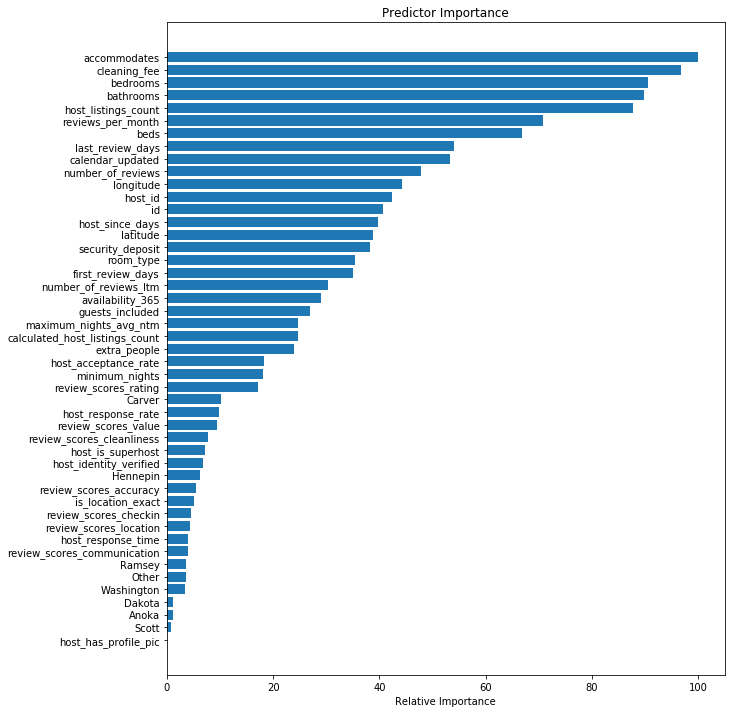

In [70]:
#Which features contributed the most to the model?

predictor_importance = rf_GSCV.best_estimator_.feature_importances_
# Rescale to 0-100
predictor_importance = 100.0 * (predictor_importance / predictor_importance.max())

#Sort them
index = np.argsort(predictor_importance)
pos = np.arange(index.shape[0])
pvals = predictor_importance[index]
pcols = X_train.columns[index]

# plots the figure
plt.figure(figsize = (10,12))
plt.barh(pos, pvals, align = 'center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Predictor Importance')
plt.show()

The most important feature is how many people the listing can accommodate. This makes sense, and it is correlated to the number of rooms and beds and bathrooms. The more people, the more space, it is expected that the price will increase. The host_listings_count also is important, maybe the more listings, it could be a company or more professional, and they charge more to stay in business.

There are also some more columns that should be excluded when making the model:
'host_id','id'